# <font size="7"> **Assignment-6**</font>
I hope this assignment will give you clarity on how mathematical models like **Multilayer Perceptrons (MLP)** can be made from scratch using **PyTorch** & can be used to solve complex, non-linear geometric problems **without relying on black-box libraries**.

---
# ⚫ **Mission Critical: The Exclusion Zone Protocol**

**Date:** Year 2142  
**Location:** Exoplanet *Kepler-186f*   **Clearance:** IITians

---

### **⚫ The Story**
Humanity has colonized the distant exoplanet *Kepler-186f*. While the surface is habitable, the planet's magnetic core is unstable. The **Global Defense Council (GDC)** has identified a dangerous phenomenon known as the **"Radiation Ring."**

Sensors indicate that the safe zones on the planet follow a peculiar geometry:
* ⚫ **The Core Zone:** Distance $< 2$ km from the colony center (Safe).
* ⚫ **The Outer Wilds:** Distance $> 4$ km from the colony center (Safe).
* ⚫ **The Dead Zone:** The region **between 2 km and 4 km** is flooded with lethal gamma radiation.

Your engineering team has deployed **3,000 sensor drones** across the colony to map this danger. Each drone reports its coordinates $(x, y)$ and a binary label:
* `1`: Radiation Detected (Dead Zone)
* `0`: Safe Zone

 **⚫ The Problem:** The sensors are cheap and prone to interference. Approximately **5%** of the drones are malfunctioning and reporting the wrong safety status (noise). The GDC mainframe is a legacy system that forbids the use of modern "Neural Libraries" (i.e., you cannot use `torch.nn` or `torch.optim`). You must build a **Multi-Layer Perceptron (MLP) from scratch** to filter out the noise and mathematically define the Exclusion Zone boundaries using **PyTorch**. ( Hint: You know this is a binary classification problem, which Loss function would you use?? )

---

### **⚫ Your Objective**

1.  **Initialize the System:** Use your **Group Number** as the random seed. This ensures your team works on a unique sensor distribution pattern.
2.  **Architect the Filter:** Construct a neural network with **3 hidden layers** (16 neurons each) to learn the non-linear "donut" shape of the Dead Zone.
3.  **Manual Calibration:** You cannot use auto-optimizers. You must manually calculate the gradients (Backpropagation) and update the system weights using **Gradient Descent**.
4.  **Verify Integrity:** Split your sensor data (70% training, 30% validation). Prove that your system doesn't just memorize the malfunctioning sensors (overfitting) but actually learns the geometric shape of the Dead Zone.

---

## ⚫ Engineering Constraints (Read Carefully)

**1. Restricted Modules**
*  **Forbidden:** You are strictly forbidden from importing `torch.nn` (Layers/Loss) or `torch.optim` (Optimizers).
*  **Allowed:** `import torch`, `import matplotlib.pyplot`, `import pandas`, `import numpy`, using `sklearn`.


**2. The Mechanics**
* **Forward Pass:** Must be implemented using raw matrix multiplication (`torch.matmul`) and bias addition.
* **Backward Pass:** You **MAY** use `loss.backward()` to compute gradients automatically (Autograd).
* **Optimization:** You **MUST** implement the weight updates manually (Stochastic Gradient Descent).
    > `w_new = w_old - learning_rate * w_old.grad`

**3. Loss Function**
Since `torch.nn` is banned, you must implement **Binary Cross Entropy** manually using basic tensor math.

$$Loss = -\frac{1}{N} \sum_{i=1}^{N} [y_i \cdot \log(\hat{y}_i) + (1-y_i) \cdot \log(1-\hat{y}_i)]$$

* **Note:** Ensure you handle the log of zero (numerical stability) or use `torch.clamp` to avoid `NaN` errors.

**4. Visual Proof:** Your final output must include a Decision Boundary Map showing the "Donut" shape.


---

### ⚫ **The GDC Dashboard (Required Output)**



The Global Defense Council requires visual confirmation that your system is stable before we can upload it to the drone fleet. You must generate a **3-Panel Heads-Up Display (HUD)** containing the following telemetry:

**1. System Error Trajectory (Loss Plot)**
* **Mission:** Plot the **Training Loss** (Blue) vs. **Validation Loss** (Orange) over all epochs.
* **Why:** We need to confirm that the system is actually learning and not just diverging (exploding gradients).

**2. Integrity Check (Accuracy Plot)**
* **Mission:** Plot the **Training Accuracy** vs. **Validation Accuracy**.
* **Why:** If Training Accuracy is high (95%) but Validation Accuracy is low (80%), you have failed to generalize. This is a sign of **Overfitting**—memorizing sensor noise instead of the Radiation Ring.

**3. Geospatial Threat Map (Decision Boundary)**
* **Mission:** Visualize the **Validation Set** on a 2D map.
* **Overlay:** Draw the neural network's **Decision Boundary** (the contours where confidence = 0.5).
* **Why:** The Commander needs to *see* the "Donut" shape. If your boundary looks like a jagged mess, the model is rejected.

---

In [1]:
import torch
import numpy as np
# ===========================================================
# PART 1: Data Generation (The Exclusion Zone)
# ===========================================================

# ⚠️ INSTRUCTION: Replace 1 with your actual Group Number
GROUP_NUMBER = 9

# Set seed for reproducibility
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)

def generate_data(n_samples=3000):
    """
    Generates 3000 sensor readings for the Kepler-186f Exclusion Zone.
    Shape: Concentric circles (Donut).
    Logic:
      - Dead Zone (1): 2km < distance < 4km
      - Safe Zone (0): distance < 2km OR distance > 4km
    """
    # Generate random coordinates between -5 and 5 km
    X = (torch.rand(n_samples, 2) * 10) - 5

    # Calculate distance from center (radius)
    radius = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)

    # Assign Labels: 1 if inside the Dead Zone, 0 otherwise
    y = ((radius > 2) & (radius < 4)).float().view(-1, 1)

    # Add 5% Noise (Malfunctioning Drones)
    n_noise = int(0.05 * n_samples)
    noise_indices = torch.randperm(n_samples)[:n_noise]
    y[noise_indices] = 1 - y[noise_indices] # Flip labels

    return X, y

# Generate the dataset
X_full, y_full = generate_data(3000)

print(f"Data Generated: {X_full.shape} samples.")
print(f"Target Generated: {y_full.shape} labels.")

Data Generated: torch.Size([3000, 2]) samples.
Target Generated: torch.Size([3000, 1]) labels.


In [2]:
# ==============================================================================
# Code from here. Best of luckk :)
# ==============================================================================
#spliting data set
train_size = int(0.7*3000)

#shuffling indices
indices = torch.randperm(3000)
train_idx, val_idx= indices[:train_size], indices[train_size:]

X_train , y_train = X_full[train_idx], y_full[train_idx]
X_val, y_val= X_full[val_idx], y_full[val_idx]

print(f"Training on {X_train.shape[0]} drones, Validating on {X_val.shape[0]} drones.")

Training on 2100 drones, Validating on 900 drones.


In [3]:
#weight initialization
W1= (torch.randn(2, 16) * 0.1).detach().requires_grad_(True)
b1= torch.zeros(1, 16, requires_grad= True)

W2= (torch.randn(16, 16) * 0.1).detach().requires_grad_(True)
b2= torch.zeros(1, 16, requires_grad= True)
W3= (torch.randn(16, 16) * 0.1).detach().requires_grad_(True)
b3= torch.zeros(1, 16, requires_grad= True)
W4= (torch.randn(16, 1) * 0.1).detach().requires_grad_(True)
b4= torch.zeros(1, 1, requires_grad= True)

#parameters
para=[W1, b1, W2, b2,W3,b3,W4,b4]


In [4]:
#forward pass function and binary cross entropy
def forward(X):
    #layer 1+Relu
    z1 = torch.matmul(X, W1) + b1
    a1= torch.relu(z1)

    z2= torch.matmul(a1, W2) +b2
    a2= torch.relu(z2)

    z3= torch.matmul(a2, W3)+b3
    a3= torch.relu(z3)

    z4= torch.matmul(a3, W4)+b4
    return torch.sigmoid(z4)

def compute_loss(y_pred, y_true):
    #clamp
    y_pred = torch.clamp(y_pred, 1e-8, 1.0- 1e-8)

    return -torch.mean(y_true*torch.log(y_pred)+(1-y_true)*torch.log(1- y_pred))

In [5]:
#hyperparameters
learn_r = 0.1
epoch = 2500

#dictionary for GDC dashboard
history= {
    'train_loss':[], 'val_loss':[],
    'train_acc':[], 'val_acc':[]
}

print("Starting Mission: Training the Radiation Filter.")

for ep in range(epoch):
    y_pred_train = forward(X_train)

    # loss
    loss= compute_loss(y_pred_train, y_train)
    #backward pass , autograd
    loss.backward()

    #optimization
    with torch.no_grad():
        for p in para:
            #updating parameter
            p -=learn_r *p.grad

            p.grad.zero_()

    if ep %100 ==0:
        with torch.no_grad():
            #checkig performance
            y_pred_val = forward(X_val)
            val_loss = compute_loss(y_pred_val, y_val)

            #accuracy
            train_acc = ((y_pred_train>0.5).float()==y_train).float().mean()
            val_acc= ((y_pred_val >0.5).float()==y_val).float().mean()

            #storing in history
            history['train_loss'].append(loss.item())
            history['val_loss'].append(val_loss.item())
            history['train_acc'].append(train_acc.item())
            history['val_acc'].append(val_acc.item())

            print(f"Epoch {epoch:4d} | Loss: {loss.item():.4f} | Val Acc: {val_acc.item():.4f}")

print("Training Complete. Generating GDC Dashboard...")

Starting Mission: Training the Radiation Filter.
Epoch 2500 | Loss: 0.6957 | Val Acc: 0.3822
Epoch 2500 | Loss: 0.6678 | Val Acc: 0.6033
Epoch 2500 | Loss: 0.6676 | Val Acc: 0.6033
Epoch 2500 | Loss: 0.6675 | Val Acc: 0.6033
Epoch 2500 | Loss: 0.6675 | Val Acc: 0.6033
Epoch 2500 | Loss: 0.6675 | Val Acc: 0.6033
Epoch 2500 | Loss: 0.6674 | Val Acc: 0.6033
Epoch 2500 | Loss: 0.6673 | Val Acc: 0.6033
Epoch 2500 | Loss: 0.6672 | Val Acc: 0.6033
Epoch 2500 | Loss: 0.6670 | Val Acc: 0.6033
Epoch 2500 | Loss: 0.6667 | Val Acc: 0.6033
Epoch 2500 | Loss: 0.6662 | Val Acc: 0.6033
Epoch 2500 | Loss: 0.6652 | Val Acc: 0.6033
Epoch 2500 | Loss: 0.6625 | Val Acc: 0.6033
Epoch 2500 | Loss: 0.6538 | Val Acc: 0.6033
Epoch 2500 | Loss: 0.6193 | Val Acc: 0.6033
Epoch 2500 | Loss: 0.5438 | Val Acc: 0.6222
Epoch 2500 | Loss: 0.4943 | Val Acc: 0.7278
Epoch 2500 | Loss: 0.4700 | Val Acc: 0.7767
Epoch 2500 | Loss: 0.4589 | Val Acc: 0.7989
Epoch 2500 | Loss: 0.4536 | Val Acc: 0.8033
Epoch 2500 | Loss: 0.4497 |

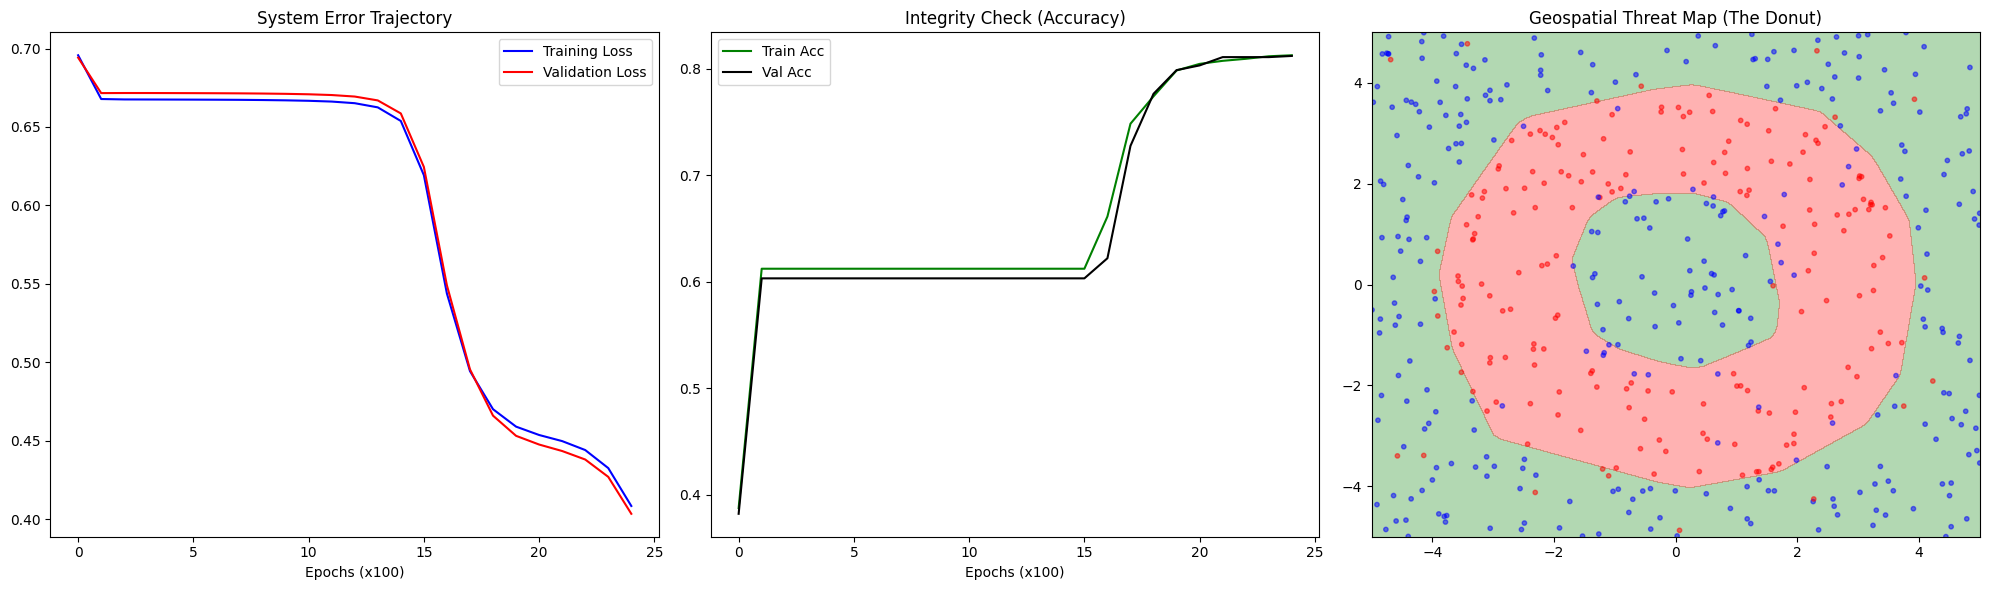

In [6]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1, 3, figsize=(20, 6))

#Loss Trajectory
ax[0].plot(history['train_loss'], label='Training Loss', color='blue')
ax[0].plot(history['val_loss'], label='Validation Loss', color='red')
ax[0].set_title("System Error Trajectory")
ax[0].set_xlabel("Epochs (x100)")
ax[0].legend()

# intergrity Check(Accuracy)
ax[1].plot(history['train_acc'], label='Train Acc', color='green')
ax[1].plot(history['val_acc'], label='Val Acc', color='black')
ax[1].set_title("Integrity Check (Accuracy)")
ax[1].set_xlabel("Epochs (x100)")
ax[1].legend()

#Geospatial Threat Map (Decision Boundary)
x_range = torch.linspace(-5, 5, 100)
y_range = torch.linspace(-5, 5, 100)
grid_x, grid_y = torch.meshgrid(x_range, y_range, indexing='ij')
grid_pts = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=1)

with torch.no_grad():
    # Pass grid through our trained filter
    grid_preds = forward(grid_pts).reshape(100, 100)

#the Donut
ax[2].contourf(grid_x.numpy(), grid_y.numpy(), grid_preds.numpy(), levels=[0, 0.5, 1], alpha=0.3, colors=['green', 'red'])
# Scatter validation drones to show they fit the boundary
ax[2].scatter(X_val[:500, 0], X_val[:500, 1], c=y_val[:500].flatten(), cmap='bwr', s=10, alpha=0.5)
ax[2].set_title("Geospatial Threat Map (The Donut)")

plt.tight_layout()
plt.show()